# Intro to Snorkel: Extracting Spouse Relations from the News

## Part II: Generating _and modeling_ noisy training labels

In this part of the tutorial, we will write **labeling functions** which express various heuristics, patterns, and [_weak supervision_](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data.

In most real-world settings, hand-labeled training data is prohibitively expensive and slow to collect. A common scenario, though, is to have access to tons of _unlabeled_ training data, and have some idea of how to label it programmatically. For example:

* We may be able to think of text patterns that would indicate two people mentioned in a sentence are married, such as seeing the word "spouse" between the mentions.
* We may have access to an external _knowledge base (KB)_ that lists some known pairs of married people, and can use these to heuristically label some subset of our data.

Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

Indicator = candidate_subclass('Indicator', ['tr', 'ind'])

Created a table in database


### Using a labeled _development set_

In our setting here, we will use the phrase "development set" to refer to a _small_ set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions. Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions.

In our case, we already loaded existing labels for a development set (`split` 1), so we can load them again now:

In [3]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
# print(L_gold_dev)

# Creating and Modeling a Noisy Training Set

Our biggest step in the data programming pipeline is the creation - _and modeling_ - of a noisy training set.  We'll approach this in three main steps:

1. **Creating labeling functions (LFs):** This is where most of our development time would actually go into if this were a real application. Labeling functions encode our heuristics and weak supervision signals to generate (noisy) labels for our training candidates.

2. **Applying the LFs:** Here, we actually use them to label our candidates!

3. **Training a generative model of our training set:** Here we learn a model over our LFs, learning their respective accuracies automatically. This will allow us to combine them into a single, higher-quality label set.

We'll also add some detail on how to go about _developing labeling functions_ and then _debugging our model_ of them to improve performance.

## 1. Creating Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse extraction task below.

A labeling function is just a Python function that accepts a `Candidate` and returns `1` to mark the `Candidate` as true, `-1` to mark the `Candidate` as false, and `0` to abstain from labeling the `Candidate` (note that the non-binary classification setting is covered in the advanced tutorials!).

In the next stages of the Snorkel pipeline, we'll train a model to learn the accuracies of the labeling functions and trewieght them accordingly, and then use them to train a downstream model. It turns out by doing this, we can get high-quality models even with lower-quality labeling functions. So they don't need to be perfect! Now on to writing some:

In [4]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

### Pattern-based LFs
These LFs express some common sense text patterns which indicate that a person pair might be married. For example, `LF_husband_wife` looks for words in `spouses` between the person mentions, and `LF_same_last_name` checks to see if the two people have the same last name (but aren't the same whole name).

In [5]:
spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}
import spacy
import time
nlpt = spacy.load('en')
# c.get_trend_token
# c.get_indicator_token
def in_trend_lexicon(word):
    trend_json = {
        "unknown": ["seasonality", "consistent", "rebound", "average", "exceed"
                                                                       "steadily", "regain", "rebound", "retrace",
                    "hyperdemic", "advance", "retreat", "up", "fall", "growth"
                                                                      "trend", "bounce", "continue", "resume", "change",
                    "unchange", "loss"],
        "single": ["peak", "minima", "maxima", "slip", "minimum", "maximum", "jump", "leap", "highest", "lowest",
                   "high", "low"],
        "linear": ["reduce", "reduction", "increase", "rise", "rising", "grow", "flat",
                   "drop", "gain", "downtrend", "plummet", "descend", "down", "decline", "downward", "firm", "fall"],
        "UNK": ["correlation", "teeter", "progression", "progress", "random", "polynomial", "parabolic",
                "hyperdemic", "trend", "exponential", "exponentially"],
        "LIN": ["downfall", "downtrend", "advance", "uptrend", "linear", "increase", "decrease", "decline",
                "grow", "rise", "drop", "climbs", "descend", "decay", "constant", "slope",
                "increment", "decrement", "plummet", "reduce", "ascent", "descent",
                "reduce", "reduction", "increase", "rise", "rising", "grow", "flat", "drop",
                "gain", "downtrend", "descend", "decline", "downward"],
        "SING": ["bump", "spike", "spiking", "crest", "jump", "pulse", "anomalous", "outlier", "gap", "peak",
                 "valley", "slip", "bounce", "jump", "leap"],
        "VAL": ["maximum", "minimum", "peak", "minima", "maxima", "average"],
        "OSC-VAR": ["inconsistent", "consistent", "hover", "steadily", "volatile", "steady", "oscillate", "flux",
                    "turbulence", "fluctuation", "fluctuate", "inflexion", "oscillation", "steady", "vacillate",
                    "cluster", "variation", "stabilize", "variance", "disperse", "settle", "divergent",
                    "consistent"],
        "SEC-LIN": ["acceleration", "accelerate", "regain", "downturn", "rebound", "retreat", "retrace",
                    "turnaround"],
        "CYC": ["wave", "sinusodal", "seasonality", "cycle", "cyclic", "sine"],
        "Missed": ["enhance", "boost", "record", "experience", "reach", "unchange", "chnaged", "climb", "nudge",
                   "surge", "narrow", "widen", "ease", "raise", "continue"]
    }

    for k in trend_json.keys():
        if word in trend_json[k]:
            return True
    return False

def pos(c):
    return str(c.pos_)

def parent(c):
    return c.head

def dep(c):
    return c.dep_

def lemma(c):
    return str(c.lemma_)

def date_signals(w):
    # kws = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
    kw_t = ["every", "weekly", "monthly", "yearly", "daily", "ago", "until", "recently", "everyday", "early",
             "recent", "annual", "weekday", "prior", "today",
            "period", "hour", "timeline", "before", "after", "later", "second", "annually",
            "biennial", "quarter", "earlier", "latest", "period", "long-term","decade", "while", "since", "during",
            ]
    if w in kw_t:
        return True
    return False

def LF_ind_relation(c):
    try:
        if pos(c.get_indicator_token()) in ['ADP', 'DET', 'CCONJ', 'PART']:
            return -1
        if parent(c.get_indicator_token()) == c.get_trend_token():
            return 1
        if parent(c.get_indicator_token()) == parent(c.get_trend_token()):
            return 1

        # if dep(c.tr) == 'conj':
        #     if parent(parent(c.tr)) == parent(c.ind):
        #         return True
        tmp = c.get_trend_token()
        while  dep(tmp) != 'ROOT' and pos(tmp) in ['NOUN', 'VERB']: #dep(tmp) not in ['det', 'pobj']
            if parent(tmp) == parent(c.get_indicator_token()):
                return 1
            tmp = parent(tmp)

        if parent(c.get_trend_token()) == c.get_indicator_token() or c.get_trend_token().head == c.get_indicator_token():
            return 1

        if parent(parent(c.get_indicator_token())) == c.get_trend_token():
            return 1
        return 0
    except:
        print('This is soo Wrong -> Indicator token is not found here')
        print (c)
        c.diagnose()
        time.sleep(60)
        return 0
        
def LF_weak_ind_relation(c):
    if pos(c.get_indicator_token()) in ['ADP', 'DET', 'CCONJ', 'PART']:
        return -1
    if dep(c.get_indicator_token()) == 'pobj' and dep(parent(c.get_indicator_token())) == 'prep':
        if parent(parent(c.get_indicator_token())) == c.get_trend_token() or parent(parent(c.get_trend_token())) == c.get_indicator_token():
            return 1
    if dep(c.get_trend_token()) == 'pobj' and dep(parent(c.get_trend_token())) == 'prep':
        if parent(c.get_indicator_token()) == parent(parent(c.get_trend_token())) or parent(parent(c.get_trend_token())) == c.get_indicator_token():
            return 1
    return 0

def LF_weak_indicator(c):
    if dep(c.get_indicator_token()) not in ["dobj", "nsubj", "pobj", "conj"]:
        return -1
    if dep(c.get_indicator_token()) == "conj":
        if dep(parent(c.get_indicator_token())) not in ["dobj", "nsubj", "pobj"]:
            return -1
    return 1

def LF_subj_indicator(c):
    # if indicator is the subject of linear change, no possible object
    if dep(c.get_indicator_token()) == 'nsubj' and  parent(c.get_indicator_token()) == c.get_trend_token() and pos(c.get_trend_token()) == 'VERB':
        for child in parent(c.get_indicator_token()).children:
            if dep(child) == 'dobj':
                # here comes the hard part #TODO: check here
                return -1

            # TODO: implement has aux and complete this part
            #             if  has_aux_v(tr_token):# if it is could, would, should, ...
            #                 return -1
            #             else:
        # return 1
        # else: #TODO: make use of this part
        #     if parent(c.ind) == parent(c.tr):
        #         return 1
    return 0

def LF_one_in_all(c):
    if parent(c.get_trend_token()) != c.get_indicator_token():
        return 0
    if dep(c.get_trend_token()) == 'amod':
        for child in c.get_indicator_token().children:
            if date_signals(child.text):
                return 1
    return -1 #TODO: check this one

def LF_verb_pobj_subj(c):
    if pos(c.get_trend_token()) == 'NOUN' and dep(c.get_trend_token()) == 'pobj':
        if pos(c.get_indicator_token()) == 'nsubj': #TODO: check for nsubjpass
            if parent(parent(c.get_trend_token())) == parent(c.get_indicator_token()):
                return 1
    return 0

def LF_shared_parent(c):
    tmp = c.get_trend_token()
    if dep(c.get_trend_token()) == 'amod' and pos(c.get_trend_token()) == 'ADJ' and not in_trend_lexicon(str(c.get_trend_token().head.text)):
        tmp = parent(c.get_trend_token())

    if parent(tmp) == parent(c.get_indicator_token()) and  pos(parent(tmp)) == 'VERB':
        if dep(tmp) == 'dobj' and (dep(c.get_indicator_token()) == 'nsubj' or dep(c.get_indicator_token()) == 'nsubjpass'):
            return 1
        # if dep(c.ind) == 'nsubj' and dep(tmp) == 'acomp' and pos(tmp) == 'ADJ':
        #     return 1
        return -1 # TODO: check, not sure about this case
    return 0

def LF_percent_child(c):
    for child in c.get_trend_token().children:
        if str(child.ent_type_) == 'PERCENT':
            return 1
    return 0

def LF_up_modifier(c):
    if str(c.get_trend_token().text).lower() not in ["up", "down"]:
        return 0
    if str(dep(c.get_trend_token())) == 'advmod':
        # if lemma(parent(c.tr)) not in ["go", "move", "edge", "nudge", "be"]:
        #     return -1
        return 1
    return 0

def LF_indicator_ent(c):
    if c.get_indicator_token().ent_type in ["DATE", "PERSON"]:
        return -1
    return 0

def LF_trend_report(c):
    if parent(c.get_indicator_token()) == parent(c.get_trend_token()) and pos(parent(c.get_trend_token())) == 'VERB' and lemma(parent(c.get_trend_token())) == 'be':
        if pos(c.get_trend_token()) == 'ADJ' and dep(c.get_indicator_token()) == 'nsubj':
            return 1
    return 0

def LF_comp_V_trend(c):
    # conj prt
    if pos(c.get_trend_token()) == 'VERB' and dep(c.get_trend_token()) == "xcomp":
        if pos(parent(c.get_trend_token())) == 'VERB':
            if in_trend_lexicon(lemma(parent(c.get_trend_token()))) and parent(c.get_indicator_token()) == parent(c.get_trend_token()) and dep(c.get_indicator_token()) == 'nsubj':
                return 1
            # return -1
        elif pos(parent(c.get_trend_token())) == 'ADJ':
            return 1
    return 0

def LF_composite_clause(c):
    if pos(c.get_trend_token()) == 'advcl' and in_trend_lexicon(parent(c.get_trend_token())):
        for child in c.get_indicator_token().children:
            if pos(child) == 'nsubj' and child != c.get_indicator_token():
                return -1
        if parent(c.get_indicator_token()) == parent(parent(c.get_trend_token())):
            return 1
    return 0

def LF_linear_tense(c):
    if pos(c.get_trend_token()) != 'VERB':
        return 0
    # print (nlp.vocab.morphology.tag_map[s_token.tag_])
    if 'Tense' not in nlpt.vocab.morphology.tag_map[c.get_trend_token().tag_].keys():
        return 0
    if nlpt.vocab.morphology.tag_map[c.get_trend_token().tag_]['Tense'] == 'past':
        if 'Aspect' in nlpt.vocab.morphology.tag_map[c.get_trend_token().tag_].keys():# and nlp.vocab.morphology.tag_map[c.tr.tag_]['Aspect'] == 'perf':
            return 1

    return 0

def up_v(c):
    if str(c.get_trend_token().text).lower()  not in ["up", "down"]:
        return 0
    if dep(c.get_trend_token()) == 'compound':
        return -1
    if pos(c.get_trend_token()) != "PART" and pos(c.get_trend_token()) != "ADP":
        return 0
    if pos(parent(c.get_trend_token())) != "VERB":
        return 0
    # if lemma(parent(c.tr)) not in ["go", "move", "edge", "nudge", "sum"]:
    #     return -1
    
    # TODO: ---------------- **** take a look at tr_mean in the semantic parts
#     if not tr_mean(str(c.get_trend_token().head.lemma_) + "_" + str(c.get_trend_token().lemma_)):
#         return -1

    if dep(parent(c.get_trend_token())) == 'xcomp':
        return -1
    return 0

def LF_up_v(c):
    if up_v(c) == 1:
        if  parent(parent(c.get_trend_token())) == parent(c.get_indicator_token()):
            return 1
        return -1
    if up_v(c) == -1:
        return -1
    return 0

def LF_assertion(c):
    if pos(c.get_trend_token()) == 'NOUN' and dep(c.get_trend_token()) == 'attr':
        return -1
    return 0

def LF_compound_nouns(c):
    if pos(c.get_trend_token()) != 'NOUN':
        return 0
    # if dep(c.tr) != 'pobj':
    #     return 0
    for ch in c.get_trend_token().children:
        if str(ch.pos_) not in ['prep', 'pobj', 'det']:
            return 0
    if str(c.get_indicator_token().head.pos_) == 'ADP':
        if parent(parent(c.get_indicator_token())) == c.get_trend_token():
            return 1
        # else:
        #     return -1
    return 0

def LF_currently_changing(c):
    if pos(c.get_trend_token()) != 'VERB':
        return 0
    # has a child with aux, auxpass which is am is are..
    # head of indicator is its nsubj, nsubjpass
    has_aux_child = False
    for child in c.get_trend_token().children:
        if child.lemma_ == 'be':
            has_aux_child = True
    if not has_aux_child:
        return 0
    if dep(c.get_indicator_token()) in ['nsubj', 'nsubjpass']:
        return 1
    return 0

def LF_obj_trend(c):
    if pos(c.get_trend_token()) == 'NOUN' and dep(c.get_trend_token()) == 'dobj':
        if dep(parent(c.get_trend_token())) == "advcl":
            if parent(parent(c.get_trend_token())) == parent(c.get_indicator_token()) and dep(c.get_indicator_token()) in ['nsubj', 'nsubjpass']:
                return 1 # for the relation of trend and indicator
            return -1 # why not?
        if dep(parent(c.get_trend_token())) == "advmod": #TODO: check, Is there any example?
            return 1
        if parent(c.get_trend_token()) == parent(c.get_indicator_token()):
            if dep(c.get_indicator_token()) in ['nsubj', 'nsubjpass']:
                return 1
    return 0

def LF_static_change(c):  # progress in x, growth of y
    if pos(c.get_trend_token()) != "NOUN":
        return 0

    if parent(parent(c.get_indicator_token())) == c.get_trend_token():  # TODO: check the pobj and pre label as well
        return 1
    return 0

def LF_trend_ind_rev_dep(c):
    # if indicator is dobj --> even stronger
    if dep(c.get_trend_token()) == 'relcl':
        return -1
    if parent(c.get_trend_token()) == c.get_indicator_token():  # TODO: maybe I should not have this clause
        if dep(c.get_trend_token()) == 'amod':
            if pos(c.get_trend_token()) == 'ADJ':
                return -1
            return 1
    return 0

def LF_no_explicit_indicator(c):
    if pos(c.get_trend_token()) != 'VERB':
        return 0
    flag = False
    for child in c.get_trend_token().children:
        if dep(child) in ["subj", "subj", "subjpass", "dobj", "pobj"]:  # TODO: check with the labels? did I mean -1 or 1?
            flag = True
    if not flag:
        return -1
    return 0

def LF_prt(c):
    if pos(parent(c.get_trend_token())) != 'VERB':
        return 0
    if pos(c.get_trend_token()) != 'PART' and pos(c.get_trend_token()) != 'ADP':
        return 0
    if dep(parent(c.get_trend_token())) in ['advcl', 'acl']:
        return -1
    return 0

def LF_cause_effect(c):
    if pos(c.get_trend_token()) != 'VERB':
        return 0
    if dep(c.get_trend_token()) == 'advcl':
        return -1
    for child in c.get_trend_token().children:
        if str(child.dep_) == 'aux' and str(child.text) == 'to':  # better date and temporal signs to be added
            return -1
    return 0

def LF_trend_aux_has(c):
    if pos(c.get_trend_token()) != "VERB":
        return 0

    for child in c.get_trend_token().children:
        if dep(child) == 'aux' and pos(child) == 'VERB':
            if child.lemma_ in ["have", "had", "has"]:
                return 1
    return 0
    # if it has an aux verb which is have, has -> return 1

def LF_leaf_trend(c):
    flag = False
    for child in c.get_trend_token().children:
        flag = True
    if flag:
        return 0
    return -1
    # if trend is the leaf of dep tree -> return -1
    
def LF_cause(c):
    # if it has a advcl-VERB in its children
    if pos(c.get_trend_token()) != 'VERB':
        return 0

    for child in c.get_trend_token().children:
        if dep(child) == 'advcl' and pos(child) == 'VERB':
            return -1
    return 0

def LF_continue(c):
    if pos(c.get_trend_token()) != 'VERB':
        return 0
    if str(c.get_trend_token().lemma_) not in ["continue", "resume"]: # TODO: use wordnet to add more synonyms and antonyms
        return 0
    # there should be other trend in the sentence which is continuing(either in subject to continue to ..)
    for t in c.get_trend_token().sent:
        if t != c.get_trend_token() and in_trend_lexicon(str(t.lemma_)):
            return 1
    return -1


def LF_Pronoun(c):
    if str(c.get_indicator_token().lemma_) in ["I", "you", "he", "she", "we"]:
        return -1
    return 0

def LF_entity(c):
    if str(c.get_indicator_token().ent_type_) == 'PERSON':
        return -1
    return 0


def LF_date_interval_dep(c):
    # pobj dependant to trend + time pattern after that
    return 0

def LF_contradicting_trends(c):
    return 0

# def LF_explicit_chage(c):
#     # from x to y
#     # sometimes on the tree with changed order
#     return 0

def LF_indicator_time_dependant(c):
    # if the indicator has interval dependant which is a sign of measure ment
    return 0


    # if the indicator is from special entities like date, ... then not appropriate

def LF_same_sent(c):
    if c.tr.get_parent() != c.ind.get_parent():
        return False
    return True

def LF_inspite(c):
    # if a trend is a noun and is dependant of in spite of --> something like the lf_contradicting_trends
    return 0

def LF_subj_pron(c):
    #     if c.trend.get_attrib_tokens("pos_tags") == 'VERB':
    # if it has a child in dep tree which is subj and a prounoun (or maybe obj too)
    return 0

def LF_date_interval(c):
    # from x to y
    return 0

def LF_percent(c):
    # if percent or number is their dependant
    # if they happen to be in the text
    return 0



### Distant Supervision LFs

In addition to writing labeling functions that describe text pattern-based heuristics for labeling training examples, we can also write labeling functions that distantly supervise examples. Here, we'll load in a list of known spouse pairs and check to see if the candidate pair matches one of these.

In [6]:

def LF_temp(c):
    print(c.__class__.__name__)
    c.get_trend_token()
    return 1

For later convenience we group the labeling functions into a list.

In [7]:
LFs = [
    LF_ind_relation,
    LF_weak_ind_relation,
    LF_weak_indicator,
    LF_subj_indicator,
    LF_one_in_all,
    LF_verb_pobj_subj,
    LF_shared_parent,
    LF_percent_child,
    LF_up_modifier,
    LF_indicator_ent,
    LF_trend_report,
    LF_comp_V_trend,
    LF_composite_clause,
    LF_linear_tense,
    LF_up_v,
    LF_assertion,
    LF_compound_nouns,
    LF_currently_changing,
    LF_obj_trend,
    LF_static_change,
    LF_trend_ind_rev_dep,
    LF_no_explicit_indicator,
    LF_prt,
    LF_cause_effect,
    LF_trend_aux_has,
    LF_leaf_trend,
    LF_cause,
   # LF_continue,
    LF_Pronoun,
    LF_entity
]

### Developing Labeling Functions

Above, we've written a bunch of labeling functions already, which should give you some sense about how to go about it. While writing them, we probably want to check to make sure that they at least work as intended before adding to our set. Suppose we're thinking about writing a simple LF: 

In [8]:
def LF_wife_in_sentence(c):
    """A simple example of a labeling function"""
    return 1 if 'wife' in c.get_parent().words else 0

One simple thing we can do is quickly test it on our development set (or any other set), without saving it to the database.  This is simple to do. For example, we can easily get every candidate that this LF labels as true:

In [9]:
labeled = []
for c in session.query(Indicator).filter(Indicator.split == 1).all():
    if LF_entity(c) != 0:
        labeled.append(c)

print("Number labeled:", len(labeled))

Number labeled: 0


We can then easily put this into the Viewer as usual (try it out!):
```
SentenceNgramViewer(labeled, session)
```

We also have a simple helper function for getting the empirical accuracy of a single LF with respect to the development set labels for example. This function also returns the evaluation buckets of the candidates (true positive, false positive, true negative, false negative):

In [10]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_wife_in_sentence, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 2. Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [11]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

Finally, we run the `labeler`. Note that we set a random seed for reproducibility, since some of the LFs involve random number generators. Again, this can be run in parallel, given an appropriate database like Postgres is being used:

In [12]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

  0%|          | 10/4412 [00:00<00:46, 94.28it/s]

Clearing existing...
Running UDF...


100%|██████████| 4412/4412 [00:36<00:00, 121.59it/s]

CPU times: user 36.5 s, sys: 126 ms, total: 36.6 s
Wall time: 36.4 s


<4412x29 sparse matrix of type '<class 'numpy.int64'>'
	with 11233 stored elements in Compressed Sparse Row format>

If we've already created the labels (saved in the database), we can load them in as a sparse matrix here too:

In [13]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 107 ms


<4412x29 sparse matrix of type '<class 'numpy.int64'>'
	with 11233 stored elements in Compressed Sparse Row format>

Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [14]:
L_train.get_candidate(session, 0)

Indicator(Span("b'highest'", sentence=293, chars=[70,76], words=[13,13]), Span("b'1.7'", sentence=293, chars=[45,47], words=[7,7]))

In [15]:
L_train.get_key(session, 0)

LabelKey (LF_ind_relation)

We can also view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [16]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_ind_relation,0,0.269492,0.269492,0.246374
LF_weak_ind_relation,1,0.046238,0.046238,0.026519
LF_weak_indicator,2,1.000000,0.870127,0.548051
LF_subj_indicator,3,0.009293,0.009293,0.009293
LF_one_in_all,4,0.023119,0.023119,0.023119
LF_verb_pobj_subj,5,0.000000,0.000000,0.000000
LF_shared_parent,6,0.094742,0.094742,0.092022
LF_percent_child,7,0.329556,0.329556,0.269266
LF_up_modifier,8,0.056890,0.056890,0.050997
LF_indicator_ent,9,0.000000,0.000000,0.000000


## 3. Fitting the Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [17]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [18]:
gen_model.weights.lf_accuracy

array([  1.02402862e-03,   1.18329296e-01,   1.49606713e+00,
         7.11712806e-02,   9.03893030e-02,   7.42729218e-02,
         1.13871061e-01,  -4.51590981e-02,   5.66654189e-02,
         7.53495396e-02,   7.77653575e-02,   7.31348107e-02,
         7.66393137e-02,   7.20487466e-02,   7.56543137e-02,
         7.49481290e-02,   7.36261439e-02,   7.42531076e-02,
         8.94130500e-02,   7.86576493e-02,   8.30253789e-02,
         2.38681537e-01,   7.97229069e-02,   1.21248368e-01,
         7.12992750e-02,   2.07527867e-01,   1.20097883e-01,
         7.15447065e-02,   7.41583329e-02])

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [19]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

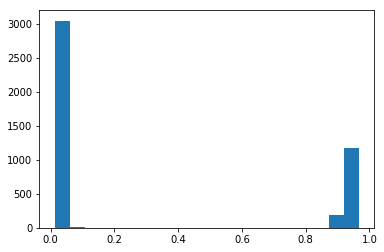

In [20]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters, and other statistics about the LFs learned by the generative model:

In [21]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.487110,0.6672,0.498968,0.333268
1,0.571773,0.6632,0.579591,0.373425
2,0.951004,0.8266,0.951528,0.784449
3,0.536153,0.6763,0.547220,0.366142
4,0.532963,0.6659,0.543833,0.354134
5,0.535375,0.6728,0.540313,0.353543
6,0.563127,0.6677,0.567092,0.367717
7,0.473105,0.6637,0.479297,0.316732
8,0.520992,0.6693,0.530135,0.348031
9,0.544144,0.6728,0.551785,0.368110


### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set.  First, we apply the LFs to our development set:

In [22]:
L_dev = labeler.apply_existing(split=1)

  1%|          | 8/758 [00:00<00:10, 69.62it/s]

Clearing existing...
Running UDF...


100%|██████████| 758/758 [00:08<00:00, 86.96it/s] 


And finally, we get the score of the generative model:

In [23]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.731
Neg. class accuracy: 0.691
Precision            0.0776
Recall               0.731
F1                   0.14
----------------------------------------
TP: 19 | FP: 226 | TN: 506 | FN: 7



### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.4 to 0.5 on the development set, which is pretty good!  However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!  

In fact, it is probably somewhat _overfit_ to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a _blind_ test set (i.e. one we never looked at during development).

### Doing Some Error Analysis

At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions.  To do this, we can again just use the `Viewer`:

In [24]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [25]:
sv

SentenceNgramViewer(cids=[[[103, 104, 105, 106, 107, 108, 109, 110, 163, 164, 165, 166, 167, 168, 169, 170], […

In [26]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

Indicator(Span("b'Consistent'", sentence=386, chars=[0,9], words=[0,0]), Span("b'stability'", sentence=386, chars=[98,106], words=[15,15]))

We can easily see the labels that the LFs gave to this candidate using simple ORM-enabled syntax:

In [27]:
c.labels

[Label (LF_weak_indicator = 1)]

We can also now explore some of the additional functionalities of the `lf_stats` method for our dev set LF labels, `L_dev`: we can plug in the gold labels that we have, and the accuracies that our generative model has learned:

In [28]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/home/pegah/anaconda3/envs/snorkel/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_ind_relation,0,0.300792,0.300792,0.269129,21,197,0,10,0.135965,0.488068
LF_weak_ind_relation,1,0.047493,0.047493,0.023747,1,25,0,10,0.305556,0.554181
LF_weak_indicator,2,1.000000,0.837731,0.544855,19,226,7,506,0.692612,0.949952
LF_subj_indicator,3,0.003958,0.003958,0.003958,0,0,3,0,0.000000,0.539774
LF_one_in_all,4,0.032982,0.032982,0.032982,1,0,0,24,1.000000,0.536530
LF_verb_pobj_subj,5,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.539106
LF_shared_parent,6,0.101583,0.101583,0.089710,1,1,12,63,0.831169,0.560360
LF_percent_child,7,0.135884,0.135884,0.134565,4,99,0,0,0.038835,0.487652
LF_up_modifier,8,0.025066,0.025066,0.025066,1,18,0,0,0.052632,0.531883
LF_indicator_ent,9,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.537068


Note that for labeling functions with low coverage, our learned accuracies are closer to our prior of 70% accuracy.

### Saving our training labels

Finally, we'll save the `training_marginals`, which are our **probabilistic training labels**, so that we can use them in the next tutorial to train our end extraction model:

In [29]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 4412 marginals
CPU times: user 2.51 s, sys: 0 ns, total: 2.51 s
Wall time: 2.52 s


Next, in Part III, we'll use these probabilistic training labels to train a deep neural network.